In [1]:
import os
os.chdir('/kaggle/input/semantic-segmentation-data-v03')

In [2]:
! ls

/bin/bash: /opt/conda/lib/libtinfo.so.6: no version information available (required by /bin/bash)
image-test-data-file.npy   labels-train.npy	     simple_multi_unet_model.py
image-train-data-file.npy  mask-test-data-file.npy
labels-test.npy		   mask-train-data-file.npy


In [3]:
! pip install segmentation-models

/bin/bash: /opt/conda/lib/libtinfo.so.6: no version information available (required by /bin/bash)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 744.5 kB/s eta 0:00:00


In [4]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

import simple_multi_unet_model #local import
from tensorflow.keras.metrics import MeanIoU
import segmentation_models as sm

Segmentation Models: using `keras` framework.


In [5]:
image_train_dataset = np.load('image-train-data-file.npy')
mask_train_dataset = np.load('mask-train-data-file.npy')

In [6]:
image_test_dataset = np.load('image-test-data-file.npy')
mask_test_dataset = np.load('mask-test-data-file.npy')

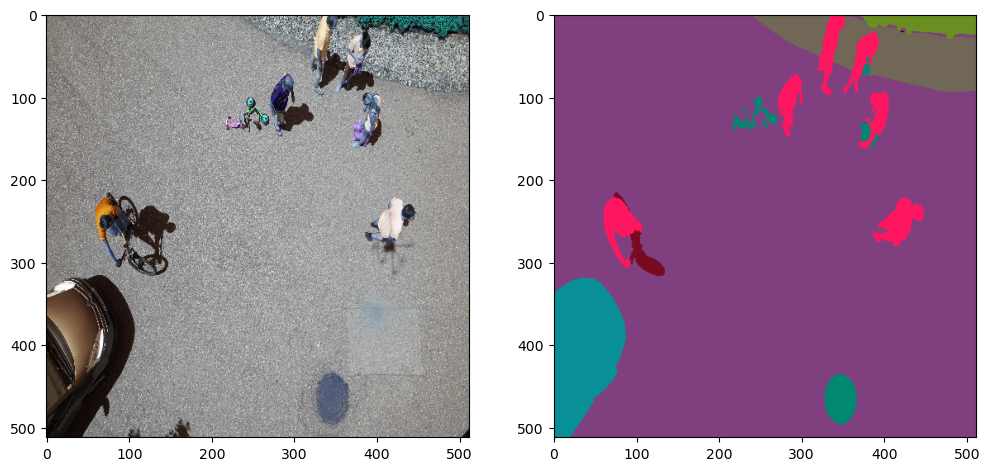

In [7]:
# Checking if train set is done right

import random
image_number = random.randint(0, len(image_train_dataset))
#image_number = 16
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(image_train_dataset[image_number])
plt.subplot(122)
plt.imshow(mask_train_dataset[image_number])
plt.show()

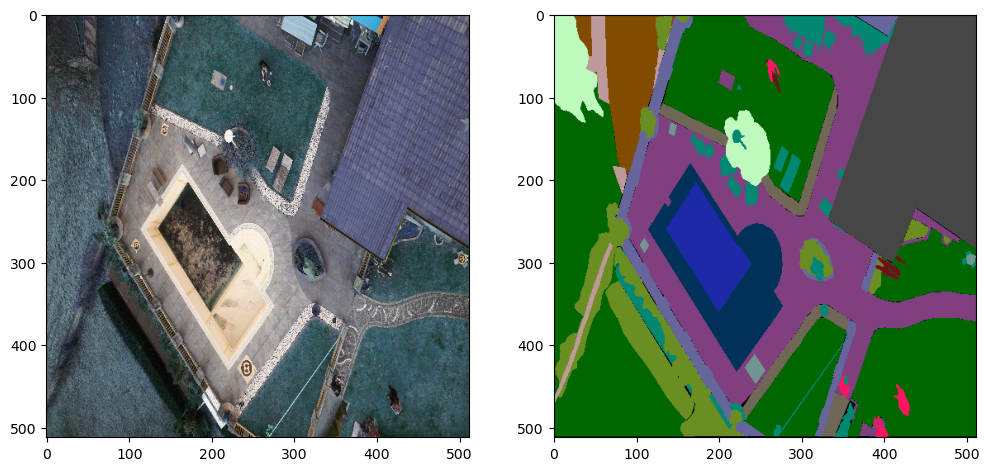

In [8]:
# checking if test set is done right

import random
image_number = random.randint(0, len(image_test_dataset))
#image_number = 16
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(image_test_dataset[image_number])
plt.subplot(122)
plt.imshow(mask_test_dataset[image_number])
plt.show()

In [9]:
labels_train = np.load('labels-train.npy') 
print("Unique labels in label training dataset are: ", np.unique(labels_train))

Unique labels in label training dataset are:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22]


In [10]:
labels_test = np.load('labels-test.npy')  
print("Unique labels in label testing dataset are: ", np.unique(labels_test))

Unique labels in label testing dataset are:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22]


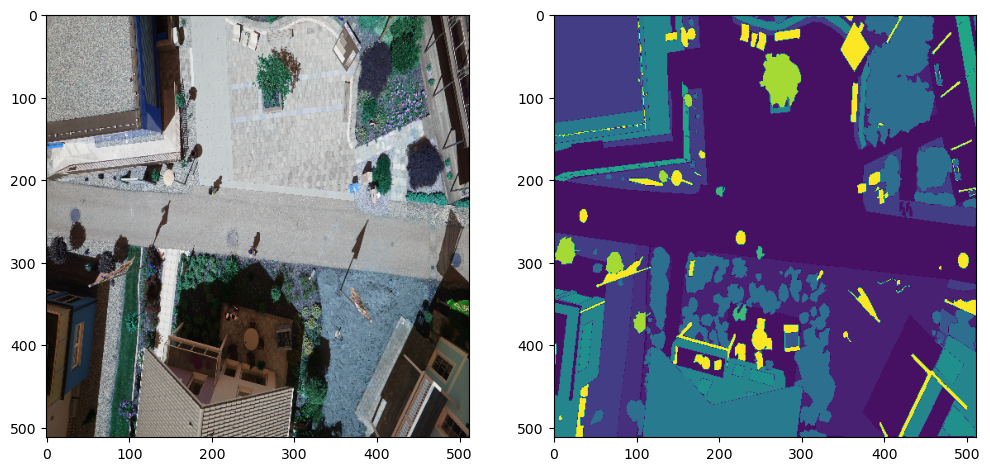

In [11]:
# Checking if integer encoding is done right

import random
import numpy as np
image_number = random.randint(0, len(image_train_dataset))
#image_number = 16
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(image_train_dataset[image_number])
plt.subplot(122)
plt.imshow(labels_train[image_number][:,:,0])
plt.show()

In [12]:
n_classes = len(np.unique(labels_train))

#from keras.utils import to_categorical
from tensorflow.keras.utils import to_categorical
labels_train_cat = to_categorical(labels_train, num_classes=n_classes)
labels_test_cat = to_categorical(labels_test, num_classes=n_classes)

In [13]:
# Manually creating train-test split as scikit learn casuses memory issue

X_train, X_test, y_train, y_test = image_train_dataset, image_test_dataset, labels_train_cat, labels_test_cat

In [14]:
weights = [(1/23) for x in range(23)]
dice_loss = sm.losses.DiceLoss(class_weights=weights) 
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)


IMG_HEIGHT = X_train.shape[1]
IMG_WIDTH  = X_train.shape[2]
IMG_CHANNELS = X_train.shape[3]

In [15]:
from simple_multi_unet_model import multi_unet_model, jacard_coef  

metrics=['accuracy', jacard_coef]

def get_model():
    return multi_unet_model(n_classes=n_classes, IMG_HEIGHT=IMG_HEIGHT, IMG_WIDTH=IMG_WIDTH, IMG_CHANNELS=IMG_CHANNELS)

model = get_model()
model.compile(optimizer='adam', loss=total_loss, metrics=metrics)
#model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=metrics)
model.summary()


history1 = model.fit(X_train, y_train, 
                    batch_size = 10, 
                    verbose=1, 
                    epochs=60, 
                    validation_data=(X_test, y_test), 
                    shuffle=False)

model.save('/kaggle/working/ran60epoch.hdf5')

2023-02-18 11:30:04.409321: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib/python3.7/site-packages/cv2/../../lib64:/usr/local/cuda/lib64:/usr/local/cuda/lib:/usr/local/lib/x86_64-linux-gnu:/usr/local/nvidia/lib:/usr/local/nvidia/lib64::/opt/conda/lib
2023-02-18 11:30:04.409398: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 512, 512, 16  448         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 dropout (Dropout)              (None, 512, 512, 16  0           ['conv2d[0][0]']                 
                                )                                                             

2023-02-18 11:30:05.429594: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 7717519360 exceeds 10% of free system memory.


Epoch 1/60
32/32 [==============================] - ETA: 0s - loss: 1.1140 - accuracy: 0.3171 - jacard_coef: 0.1928 

2023-02-18 11:41:58.591975: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1929379840 exceeds 10% of free system memory.


32/32 [==============================] - 744s 23s/step - loss: 1.1140 - accuracy: 0.3171 - jacard_coef: 0.1928 - val_loss: 1.0997 - val_accuracy: 0.3780 - val_jacard_coef: 0.2337
Epoch 2/60
32/32 [==============================] - 706s 22s/step - loss: 1.0597 - accuracy: 0.2065 - jacard_coef: 0.0974 - val_loss: 1.0294 - val_accuracy: 0.0685 - val_jacard_coef: 0.0234
Epoch 3/60
32/32 [==============================] - 698s 22s/step - loss: 1.0283 - accuracy: 0.2586 - jacard_coef: 0.0435 - val_loss: 1.0269 - val_accuracy: 0.3735 - val_jacard_coef: 0.0317
Epoch 4/60
32/32 [==============================] - 698s 22s/step - loss: 1.0251 - accuracy: 0.4002 - jacard_coef: 0.0791 - val_loss: 1.0277 - val_accuracy: 0.2060 - val_jacard_coef: 0.0272
Epoch 5/60
32/32 [==============================] - 702s 22s/step - loss: 1.0205 - accuracy: 0.4589 - jacard_coef: 0.1164 - val_loss: 1.0241 - val_accuracy: 0.4465 - val_jacard_coef: 0.0474
Epoch 6/60
32/32 [==============================] - 702s 22s/

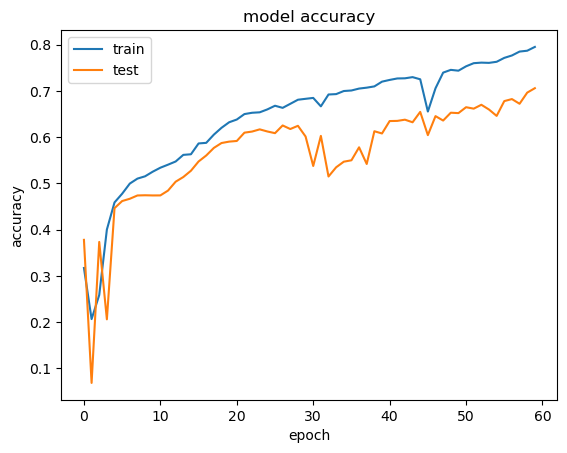

In [16]:
plt.plot(history1.history['accuracy'])
plt.plot(history1.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

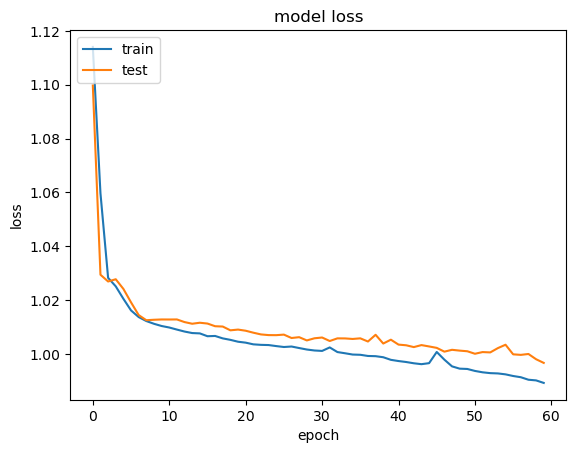

In [17]:
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

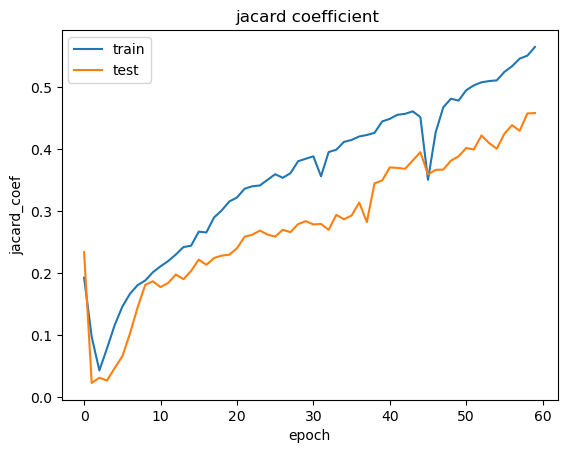

In [18]:
plt.plot(history1.history['jacard_coef'])
plt.plot(history1.history['val_jacard_coef'])
plt.title('jacard coefficient ')
plt.ylabel('jacard_coef')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [19]:
! pip install pickle5


/bin/bash: /opt/conda/lib/libtinfo.so.6: no version information available (required by /bin/bash)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 256.4/256.4 kB 546.6 kB/s eta 0:00:00


In [20]:
type(history1)

keras.callbacks.History

In [21]:
history1.history.keys()

dict_keys(['loss', 'accuracy', 'jacard_coef', 'val_loss', 'val_accuracy', 'val_jacard_coef'])